In [ ]:
import numpy as np

## **Twisted String Kinematics**

According to the conventional kinematic of the twisted string actuator the relationships between string contraction $X$ and motor angle $\theta$ are governed by following constraint:
\begin{equation}
\theta^2 r^2 + (L-X)^2 - L^2 = 0
\end{equation}
Using the constraint above one can easily find the contraction $X$ of strings given the motor angle $\theta$ (forward kinematics of TSA):
\begin{equation}
X = L - \sqrt{L^2 - \theta^2 r^2}
\end{equation}




In [ ]:
def theta2x(theta, L, r):
    return L - np.sqrt(L**2 - (theta* r)**2)

In turn, if it is desirable to find the motor angle $\theta$ for given contraction $\mathbf{X}$ (inverse kinematics of TSA) one would end up with following: 

\begin{equation}
\theta = \pm \frac{\sqrt{L^2 - (L-X)^2}}{r}
\end{equation}


In [ ]:
def x2theta(X, L, r, sign = 1):
    return sign*np.sqrt(L**2 - (L- X)**2)/r


To deduce the velocity relations one may differentiate expression above to get:
\begin{equation}
\dot{X} = \frac{\theta r^2}{L-X}\dot{\theta} = \mathcal{J}^s(\theta, X)\dot{\theta}
\end{equation}

where $\mathcal{J}^s(\theta, X)$ is the jacobian of twisted strings. 

In [ ]:
def tsa_jacobian(theta, X, L, r):
    return theta* r**2/(L-X)

def tsa_jacobian_theta(theta, L, r):
    X = theta2x(theta, L, r)
    return tsa_jacobian(theta, X, L, r)

def tsa_jacobian_x(X, L, r):
    theta = x2theta(X, L, r, sign = 1)
    return tsa_jacobian(theta, X, L, r)


## **Device Kinematics**

Let us proceed with the deriving the kinematic relationships of the device.

In [ ]:
# PARAMETERS OF THE DEVICE
d = 15 # mm 
D = 110 # mm
R = 33  # mm
l = 213.20 # mm
d_c = 93.5 # mm
L = [280, 280, 280, 330] # mm
r = [0.8, 0.8, 0.8, 0.8] # mm
rc_4 = np.array([0,0, -185])

phi_angles = [2*np.pi*(i)/3 + np.pi/2 for i in range(3)]



The position of lateral carriages connected to the end of twisted strings as follows:
\begin{equation}
    \mathbf{r}^c_i =  
    \begin{bmatrix}
        (D-d)\cos \varphi_i \\ 
        (D-d)\sin \varphi_i \\ 
        X_i - L_i + d_c
    \end{bmatrix}
\end{equation}

In [ ]:
def carriage_pos(X, phi, L):    
    rc_x = (D - d)*np.cos(phi)
    rc_y = (D - d)*np.sin(phi)
    rc_z = X - L + d_c
    return np.array([rc_x, rc_y, rc_z])

The carriages are connected to the hinges installed on the frame of end effector through rigid rods of lengths $\ell$. Position of each such hinge with respect to end effector frame may be calculated as follows:
\begin{equation}
    \mathbf{r}^h_i =  
    \begin{bmatrix}
        R\cos \varphi_i\\ 
        R\sin \varphi_i\\ 
        0
    \end{bmatrix}
\end{equation}

In [ ]:
frame_hinges_loc_pos = np.array([R*np.cos(phi_angles), 
                                 R*np.sin(phi_angles), 
                                 np.zeros(3)]).T
frame_hinges_loc_pos[0]


array([2.02066722e-15, 3.30000000e+01, 0.00000000e+00])

While the very same position with respect to world frame is given by:
\begin{equation}
    \mathbf{r}^f_i = \mathbf{r}^e + \mathbf{r}^h_i
\end{equation}


Since the difference between end effector frame and carriage hinges is equal to the length of rods the kinematics of the device should obey following constraints:
\begin{equation}
    \|\mathbf{r}^c_i -  \mathbf{r}^f_i\|^2_2 = \ell^2
\end{equation}
The central "pulling" TSA module is shifted to $\mathbf{r}^c_4$ and directly connected to the center of end effector frame: 
\begin{equation}
    \|\mathbf{r}^c_4 -  \mathbf{r}^e\|^2_2 = (L_4 - X_4)^2
\end{equation}



### **Forward Kinematics**
Since the position of end effector is not measured directly, once would need to use available contraction measurements coming from the linear position sensors installed in the carriages. Thus given $X_1, X_2, X_3$ one need to solve the constraints above for $\mathbf{r}^e$:
\begin{equation}
    \|(\mathbf{r}^c_i -  \mathbf{r}^h_i) -  \mathbf{r}^e\|^2_2 = \ell^2
\end{equation}
The problem stated above is well known as trilateration and widely used in GPS navigation. 

In [ ]:
def trilaterate(spheres_centers,spheres_radii):   
    ''' Find the intersection of three spheres, 
        spheres_centers = [p1,p2,p3] are the centers, 
        spheres_radii = [r1,r2,r3] are the radii  
        ''' 

    p1, p2, p3 = spheres_centers
    r1, r2, r3 = spheres_radii

    temp1 = p2-p1
    e_x = (temp1)/np.linalg.norm(temp1)                              
    
    temp2 = p3-p1                                        
    i = e_x @ temp2                                   
    temp3 = temp2 - i*e_x                                
    e_y = temp3/np.linalg.norm(temp3)                              
    e_z = np.cross(e_x,e_y)                                 
    d = np.linalg.norm(p2-p1)                                      
    j = e_y @ temp2                                   
    x = (r1*r1 - r2*r2 + d*d) / (2*d)                    
    y = (r1*r1 - r3*r3 -2*i*x + i*i + j*j) / (2*j)       
    temp4 = r1*r1 - x*x - y*y                            
    if temp4<0:                                          
        raise Exception("The three spheres do not intersect!");
    z = np.sqrt(temp4)                                      
    intersection = p1 + x*e_x + y*e_y + z*e_z                  
               
    return intersection                      

In [ ]:
def forward_kinemaitcs(contractions):
    spheres_centers = 3*[0]
    spheres_radii = np.array([l,l,l])

    for i in range(3):
        rc_i = carriage_pos(contractions[i], phi_angles[i], L[i])
        rh_i = frame_hinges_loc_pos[i]
        spheres_centers[i] = rc_i - rh_i
    
    end_effector_pos = trilaterate(spheres_centers, spheres_radii)
    return end_effector_pos

In [ ]:
forward_kinemaitcs([0, 0, 0, _])




array([ 7.10542736e-15, -7.10542736e-15,  1.74858819e+01])

### **Inverse Kinematics**
The inverse kinematics is straightforwardly calculated based on constraints:
\begin{equation}
    X_i  =  
    \begin{cases}
        r^e_z  + L_i - \sqrt{\ell^2 - \|\mathbf{r}^d_i\|^2_2} - d_c  \ \text{ if } i = 1,2,3 \\ 
        L_4 - \|\mathbf{r}^e - \mathbf{r}^c_4\|_2 \ \text{ if } i = 4
    \end{cases}
\end{equation}
where the vector $\mathbf{r}^d_i$ is defined as two first components of the  $\mathbf{r}^c_i -  \mathbf{r}^f_i$ namely:

\begin{equation*}
    \mathbf{r}^d_i =  
    \begin{bmatrix}
        (D - d - R)\cos \varphi_i  - \mathbf{r}^e_x\\ 
        (D - d - R)\sin \varphi_i  - \mathbf{r}^e_y\\ 
    \end{bmatrix}
\end{equation*}

In [ ]:
def inverse_kinematics(end_eff_pos):
    X = np.zeros(4)
    re_x, re_y, re_z = end_eff_pos
    for i in range(4):
        if i == 3:
            X[i] = L[i] - np.linalg.norm(end_eff_pos - rc_4)
        else:
            rd_i = np.array([(D-d-R)*np.cos(phi_angles[i]) - re_x, 
                             (D-d-R)*np.sin(phi_angles[i]) - re_y])

            X[i] = re_z + L[i] - np.sqrt(l**2 - rd_i @ rd_i) - d_c
          
    return X
         

In [ ]:
contractions = inverse_kinematics(np.array([0,0,20]))
contractions



array([  2.51411814,   2.51411814,   2.51411814, 125.        ])

In [ ]:
forward_kinemaitcs(contractions)

array([ 7.10542736e-15, -7.10542736e-15,  2.00000000e+01])

### **Differential Kinematics**

In order to obtain the relations between the velocities of TSA carriages and end effector one may differentiate constraints to get:
\begin{equation*}
    (\mathbf{r}^c_i -  \mathbf{r}^f_i)^T(\dot{\mathbf{r}}^c_i -  \dot{\mathbf{r}}^f_i) = 0
\end{equation*}
\begin{equation*}
    (\mathbf{r}^c_4 -  \mathbf{r}^e)^T\dot{\mathbf{r}}^e = (L_4 - X_4)\dot{X}_4
\end{equation*}

Rearranging the expressions above one may dirive the differential relationships as follows:
\begin{equation}
    \dot{\mathbf{X}} = \boldsymbol{\mathcal{J}}^m(\mathbf{r}_e,\mathbf{X})\dot{\mathbf{r}}^e
\end{equation}

where $\mathbf{X} = [X_1, X_2, X_3, X_4]^T$ and the row of Jacobian matrix is given as:

\begin{equation}
    \boldsymbol{\mathcal{J}}^m_i(\mathbf{X}, \mathbf{r}_e) = 
        \begin{cases}
        \frac{(\mathbf{r}^c_i -  \mathbf{r}^f_i)^T}{X_i - L_i + d_c - \mathbf{r}^e_z} \text{ if } i = 1,2,3 \\ 
        \frac{(\mathbf{r}^c_4 -  \mathbf{r}^e)^T}{L_4 - X_4} \ \text{ if } i = 4
    \end{cases}
\end{equation}



As one can note the Jacobian is defined in terms of both string contractions and postion of end effector $\mathbf{r}^e$ while in practice the latter is not directly measured but estimated via solution of forward kinematics given the measurements of contraction associated with moving carriages $X_1, X_2, X_3$. As for the term  $L_4 - X_4$ which corresponds to the pulling module it is estimated via respective constraint $\|\mathbf{r}^c_4 -  \mathbf{r}^e\|^2_2 = (L_4 - X_4)^2$ assuming that $\mathbf{r}^e$ is already calculated as suggested above. Thus in order to calculate Jacobian one may need to measure just the positions of carriages.

The Jacobian above represents the relationship between motion in carriages and the frame of end effector, however to effectively characterize the device from the inputs (motors in TSA modules) to the end effector frame one would need to incorporate the string kinematics. To do so one may substitute the contraction speed of TSA to the $\dot{\mathbf{X}} = \boldsymbol{\mathcal{J}}^m\dot{\mathbf{r}}^e$ to obtain following:
\begin{equation}
    \dot{\boldsymbol{\theta}} = \boldsymbol{\mathcal{J}}^{d}\dot{\mathbf{r}}^e
\end{equation}
where $\boldsymbol{\mathcal{J}}^{d}$ is the Jacobian of the device from motor angle to end effector position, the columns of $\boldsymbol{\mathcal{J}}^{d}$ are given by:
\begin{equation}
    \boldsymbol{\mathcal{J}}^d_i = (\mathcal{J}^s_i)^{-1}\boldsymbol{\mathcal{J}}^m_i
\end{equation}
Note that Jacobian of the device \eqref{eq.mod:jacobian_device_col} can be written in terms of contractions $X_i$ or motor angles $\theta_i$.


In [ ]:
def jacobians(contractions):
    jac_m = np.zeros((4, 3))
    jac_d = np.zeros((4, 3))
    r_e = forward_kinemaitcs(contractions)
    
    for i in range(4):
        if i == 3:
            delta_r = rc_4 - r_e
            jac_m[i] = delta_r/np.linalg.norm(delta_r)
        else:
            rc_i = carriage_pos(contractions[i], phi_angles[i], L[i])
            rh_i = frame_hinges_loc_pos[i]
            rf_i = r_e + rh_i
            jac_m[i] = (rc_i - rf_i)/(contractions[i] - L[i] + d_c - r_e[2])

        jac_d[i] = jac_m[i]/tsa_jacobian_x(contractions[i], L[i], r[i])
        
    return jac_m, jac_d


In [ ]:
jacobian_mech, jacobian_d = jacobians(contractions)
jacobian_mech, jacobian_d

(array([[ 1.62218201e-17, -3.03942603e-01,  1.00000000e+00],
        [ 2.63222016e-01,  1.51971302e-01,  1.00000000e+00],
        [-2.63222016e-01,  1.51971302e-01,  1.00000000e+00],
        [-3.46606213e-17,  3.46606213e-17, -1.00000000e+00]]),
 array([[ 1.50293677e-16, -2.81600036e+00,  9.26490835e+00],
        [ 2.43872785e+00,  1.40800018e+00,  9.26490835e+00],
        [-2.43872785e+00,  1.40800018e+00,  9.26490835e+00],
        [-3.43453795e-17,  3.43453795e-17, -9.90904901e-01]]))

In [ ]:
np.linalg.pinv(jacobian_mech)

array([[ 0.00000000e+00,  1.89953716e+00, -1.89953716e+00,
        -2.50127778e-16],
       [-2.19339658e+00,  1.09669829e+00,  1.09669829e+00,
         4.36617651e-16],
       [ 2.50000000e-01,  2.50000000e-01,  2.50000000e-01,
        -2.50000000e-01]])

### **Workspace**

In [ ]:
samples = 10000
# X_rand = 0.3*np.diag(L) @ np.random.rand(4, samples)
 #np.random.rand(samples)
# Z_fix = 60
planes = {'xy':{}, 'zy':{}}

# end_effector_poses = np.zeros((3, samples))

end_eff_list = []
jac_m_cond = []
jac_d_cond = []
xy_norm = []
yz_norm = []
# X_list = []
for plane in ['xy', 'zy']:

    if plane == 'xy':
        re_x_rand = -80 + 160*np.random.rand(samples)
        re_y_rand = -80 + 190*np.random.rand(samples)
        re_z_rand = 60*np.ones(samples)

    if plane == 'zy':
        re_x_rand = np.zeros(samples)
        re_y_rand = -80 + 190*np.random.rand(samples)
        re_z_rand = 160*np.random.rand(samples)

    planes[plane]['r_e'] = []
    planes[plane]['jac_m_cond'] = []
    planes[plane]['jac_d_cond'] = []

    for i in range(samples):
        r_e_calc = np.array([re_x_rand[i],re_y_rand[i],re_z_rand[i]])
        X_i = inverse_kinematics(r_e_calc)

        cons_1 = np.all(np.vstack([np.cos(phi_angles), np.sin(phi_angles)]).T @ r_e_calc[:2] <= 90*np.ones(3))
        cons_2 = np.all(-np.vstack([np.cos(phi_angles), np.sin(phi_angles)]).T @ r_e_calc[:2] <= 58*np.ones(3))
        cons_3 = np.all(np.zeros(4)<=X_i)
        cons_4 = np.all(X_i<=np.array(L)*0.3)
        
        if cons_1 and cons_2 and cons_3 and cons_4:
            jacobian_m, jacobian_d = jacobians(X_i)
            planes[plane]['r_e'].append(r_e_calc)
            planes[plane]['jac_m_cond'].append(np.linalg.cond(jacobian_m))
            planes[plane]['jac_d_cond'].append(np.linalg.cond(jacobian_d))
    
    planes[plane]['r_e'] = np.array(planes[plane]['r_e'])


xy_x = planes['xy']['r_e'][:,0]
xy_y = planes['xy']['r_e'][:,1]
xy_points = len(xy_x)

zy_y = planes['zy']['r_e'][:,1]
zy_z = planes['zy']['r_e'][:,2]
zy_points = len(zy_y)



### **Jacobian Analysis**



In [ ]:
from scipy.interpolate import griddata

# jac_cond = jac_cond/jac_cond.max()


x_e_interp = np.linspace(xy_x.min(), xy_x.max(), 500)
y_e_interp = np.linspace(xy_y.min(), xy_y.max(), 500)


X_xy_e, Y_xy_e = np.meshgrid(x_e_interp, y_e_interp)


xy_jac_m_grid = griddata(points=np.vstack((xy_x, xy_y)).T,
                values=planes['xy']['jac_m_cond'], xi=(X_xy_e, Y_xy_e),
                method='cubic')

xy_jac_d_grid = griddata(points=np.vstack((xy_x, xy_y)).T,
                values=planes['xy']['jac_d_cond'], xi=(X_xy_e, Y_xy_e),
                method='cubic')


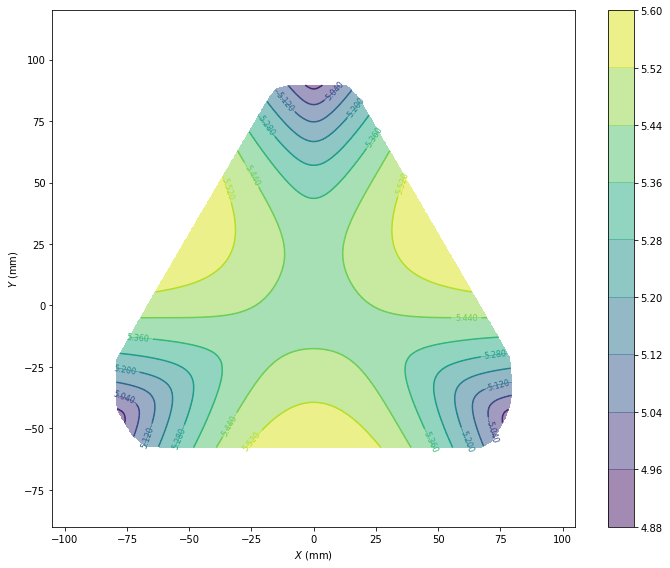

In [ ]:
# /// Contour Plot ////
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

plt.contourf(X_xy_e, Y_xy_e, xy_jac_m_grid, 8, alpha=0.5)
plt.colorbar()
contours = plt.contour(X_xy_e, Y_xy_e, xy_jac_m_grid, 8)
plt.clabel(contours, inline=True, fontsize=8)
plt.xlabel(r'$X$ (mm)')
plt.ylabel(r'$Y$ (mm)')
plt.tight_layout()
# plt.savefig(default_path + 'freq_countour.png', dpi=300)
plt.ylim([-105+15,105+15])
plt.xlim([-105,105])
plt.show()



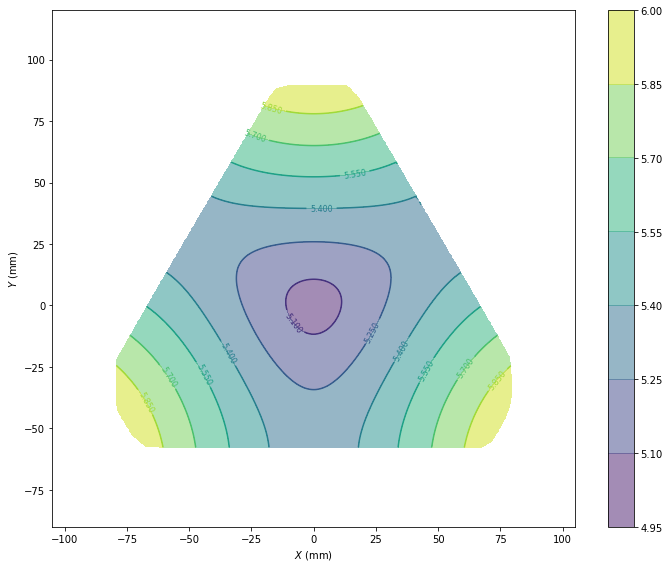

In [ ]:
# /// Contour Plot ////

plt.figure(figsize=(10, 8))

plt.contourf(X_xy_e, Y_xy_e, xy_jac_d_grid, 8, alpha=0.5)
plt.colorbar()
contours = plt.contour(X_xy_e, Y_xy_e, xy_jac_d_grid, 8)
plt.clabel(contours, inline=True, fontsize=8)
plt.xlabel(r'$X$ (mm)')
plt.ylabel(r'$Y$ (mm)')
plt.tight_layout()
# plt.savefig(default_path + 'freq_countour.png', dpi=300)
plt.ylim([-105+15,105+15])
plt.xlim([-105,105])
plt.show()

In [ ]:
z_e_interp = np.linspace(zy_z.min(), zy_z.max(), 500)
y_e_interp = np.linspace(zy_y.min(), zy_y.max(), 500)

Z_zy_e, Y_zy_e = np.meshgrid(z_e_interp, y_e_interp)

zy_jac_m_grid = griddata(points=np.vstack((zy_z, zy_y)).T,
                values=planes['zy']['jac_m_cond'], xi=(Z_zy_e, Y_zy_e),
                method='cubic')

zy_jac_d_grid = griddata(points=np.vstack((zy_z, zy_y)).T,
                values=planes['zy']['jac_d_cond'], xi=(Z_zy_e, Y_zy_e),
                method='cubic')



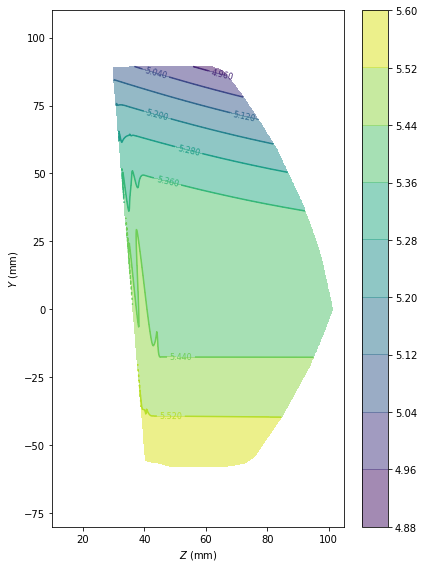

In [ ]:
# /// Contour Plot ////

plt.figure(figsize=(6, 8))
plt.contourf(Z_zy_e, Y_zy_e, zy_jac_m_grid, 8, alpha=0.5)
plt.colorbar()
contours = plt.contour(Z_zy_e, Y_zy_e, zy_jac_m_grid, 8)
plt.clabel(contours, inline=True, fontsize=8)
plt.xlabel(r'$Z$ (mm)')
plt.ylabel(r'$Y$ (mm)')

plt.tight_layout()
# plt.savefig(default_path + 'freq_countour.png', dpi=300)
plt.ylim([-80,110])
plt.xlim([10,105])
plt.show()


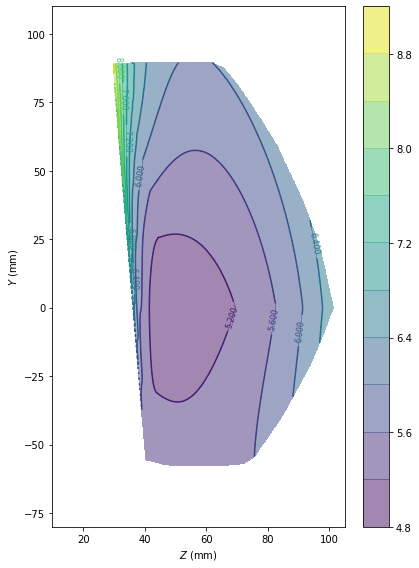

In [ ]:
plt.figure(figsize=(6, 8))
plt.contourf(Z_zy_e, Y_zy_e, zy_jac_d_grid, 10, alpha=0.5)
plt.colorbar()
contours = plt.contour(Z_zy_e, Y_zy_e, zy_jac_d_grid, 10)
plt.clabel(contours, inline=True, fontsize=8)
plt.xlabel(r'$Z$ (mm)')
plt.ylabel(r'$Y$ (mm)')
plt.tight_layout()
# plt.savefig(default_path + 'freq_countour.png', dpi=300)
plt.ylim([-80,110])
plt.xlim([10,105])
plt.show()